In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Set input layer
inputs = keras.Input(shape=(128, 128, 3), name='img')

# Patch extraction layer
x = layers.Conv2D(
    filters=64,
    kernel_size=9,
    padding='same',
    activation='relu'
)(inputs)

# Non-linear mapping layer
x = layers.Conv2D(
    filters=32,
    kernel_size=1,
    padding='same',
    activation='relu'
)(x)

# Reconstruction layer
outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,
    padding='same'
)(x)

# Set a SRCNN model
model = keras.Model(inputs, outputs, name='SRCNN')
model.summary()

Model: "SRCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      15616     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 3)       2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

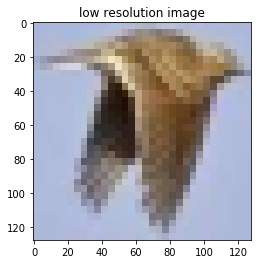

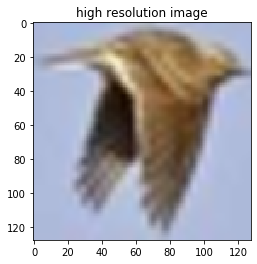

In [8]:
# Load image data
ishape = 128
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Reduce the dataset
train_image = train_images[0:10000]
test_image = test_images[0:1000]

x_train = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_NEAREST) for img in train_image])
x_test = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_NEAREST) for img in test_image])

y_train = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in train_image])
y_test = np.array([cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC) for img in test_image])

# Show an example image
example_idx = 123
plt.figure('LR')
plt.imshow(x_train[example_idx])
plt.title('low resolution image')
plt.figure('HR')
plt.imshow(y_train[example_idx])
plt.title('high resolution image')
plt.show()

In [11]:
# Train the model
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=255.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=255.0)

model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='mse', metrics=[PSNR, SSIM, 'accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)

print('Test loss:', test_scores[0])
print('Test mse:', test_scores[1])

# Save entire model to a HDF5 file
model.save('SRCNN.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
 960/8000 [==>...........................] - ETA: 11:35 - loss: 10261.2619 - PSNR: 9.3198 - SSIM: 0.3833 - accuracy: 0.1791

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


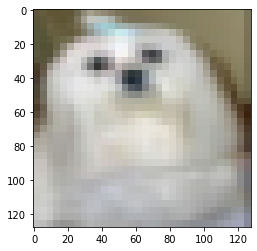

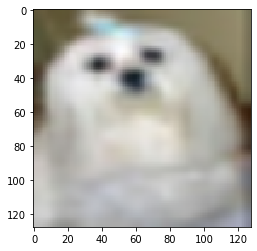

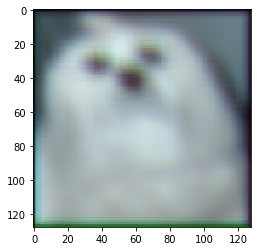

In [14]:
# Set real test image
img = train_images[20001]
lr = np.array(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_NEAREST))
hr = np.array(cv.resize(img, (ishape, ishape), interpolation=cv.INTER_CUBIC))
test_input = np.reshape(lr, (1, ishape, ishape, 3))

# Predict a result
sr = model.predict(test_input)
plt.figure('LR')
plt.imshow(lr)
plt.figure('HR')
plt.imshow(hr)
plt.figure('SR')
plt.imshow(sr[0] / 255.0)
plt.show()